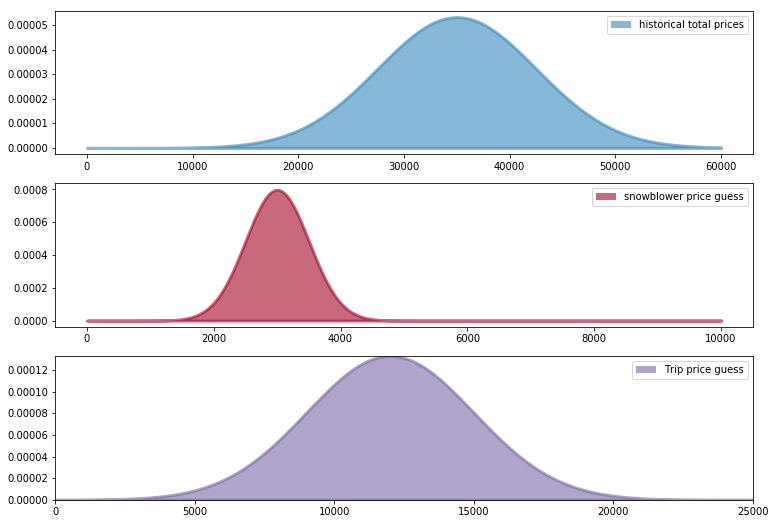

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500),
                       color="#348ABD", lw=3, alpha=0.6,
                       label="historical total prices")
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500),
                       color="#A60628", lw=3, alpha=0.6,
                       label="snowblower price guess")

p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                       color="#7A68A6", lw=3, alpha=0.6,
                       label="Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()]);

In [2]:
import pymc as pm

data_mu = [3e3, 12e3]

data_std = [5e2, 3e3]

mu_prior = 35e3
std_prior = 75e2

true_price = pm.Normal("true_price", mu_prior, 1.0 / std_prior ** 2)


prize_1 = pm.Normal("first_prize", data_mu[0], 1.0 / data_std[0] ** 2)
prize_2 = pm.Normal("second_prize", data_mu[1], 1.0 / data_std[1] ** 2)
price_estimate = prize_1 + prize_2


@pm.potential
def error(true_price=true_price, price_estimate=price_estimate):
        return pm.normal_like(true_price, price_estimate, 1 / (3e3) ** 2)


mcmc = pm.MCMC([true_price, prize_1, prize_2, price_estimate, error])
mcmc.sample(50000, 10000)

price_trace = mcmc.trace("true_price")[:]

 [-----------------100%-----------------] 50000 of 50000 complete in 6.3 sec

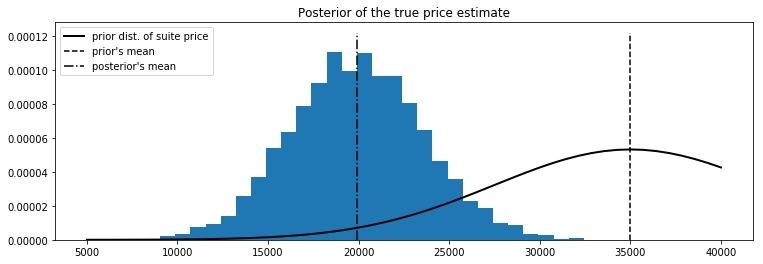

In [3]:
figsize(12.5, 4)

import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c="k", lw=2,
         label="prior dist. of suite price")

_hist = plt.hist(price_trace, bins=35, normed=True, histtype="stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1 * np.max(_hist[0]), label="prior's mean",
           linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1 * np.max(_hist[0]),
           label="posterior's mean", linestyles="-.")
plt.legend(loc="upper left");

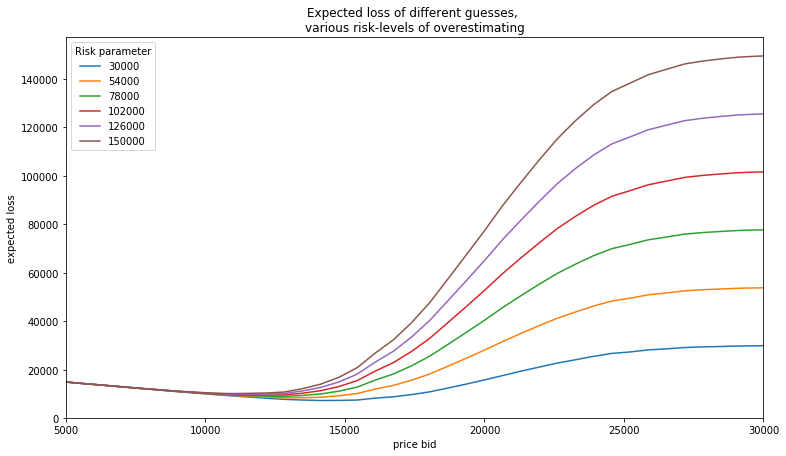

In [4]:
figsize(12.5, 7)
# numpy friendly showdown_loss


def showdown_loss(guess, true_price, risk=80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = [abs(true_price - guess) <= 250]
        loss[close_mask] = -2 * true_price[close_mask]
        loss[ix] = risk
        return loss


guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label="%d" % _p)

plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000);

minimum at risk 30000: 14658.85
minimum at risk 54000: 13035.62
minimum at risk 78000: 12832.63
minimum at risk 102000: 12222.40
minimum at risk 126000: 11119.32
minimum at risk 150000: 11025.13


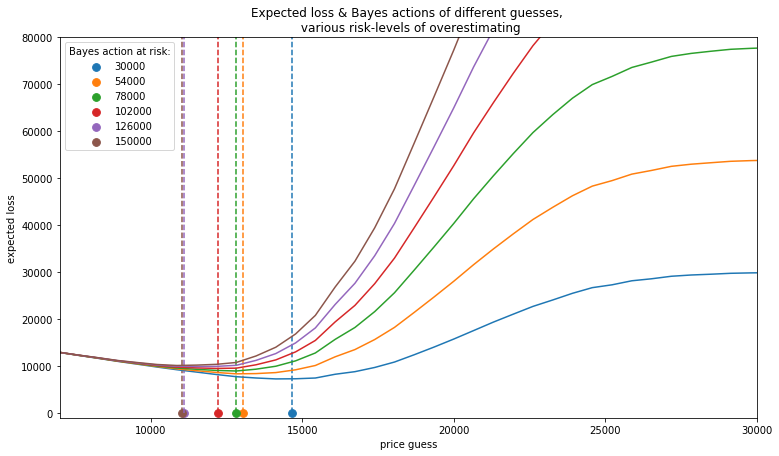

In [5]:
import scipy.optimize as sop

ax = plt.subplot(111)


for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,),disp = False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results , color = _color['color'])
    plt.scatter(_min_results, 0, s = 60, \
                color= _color['color'], label = "%d"%_p)
    plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))

plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints=1, title="Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);